In [1]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import qr
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit, RawFeatureVector
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

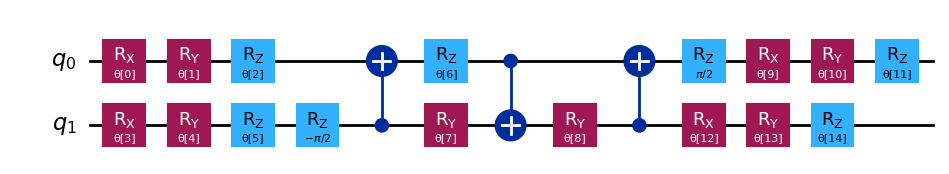

In [2]:
# We now define a two qubit unitary as defined in [3]

# Making matrices
matrix = np.random.normal
n = 2
H = np.random.randn(n, n)
Q, R = qr(H)
matrix0 = Q.dot(Q.T)
H = np.random.randn(n, n)
Q, R = qr(H)
matrix1 = Q.dot(Q.T)

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rx(params[0], 0)
    target.ry(params[1], 0)
    target.rz(params[2], 0)
    target.rx(params[3], 1)
    target.ry(params[4], 1)
    target.rz(params[5], 1)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[6], 0)
    target.ry(params[7], 1)
    target.cx(0, 1)
    target.ry(params[8], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    target.rx(params[9], 0)
    target.ry(params[10], 0)
    target.rz(params[11], 0)
    target.rx(params[12], 1)
    target.ry(params[13], 1)
    target.rz(params[14], 1)
    return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=15)
circuit = conv_circuit(params)
circuit.draw("mpl")

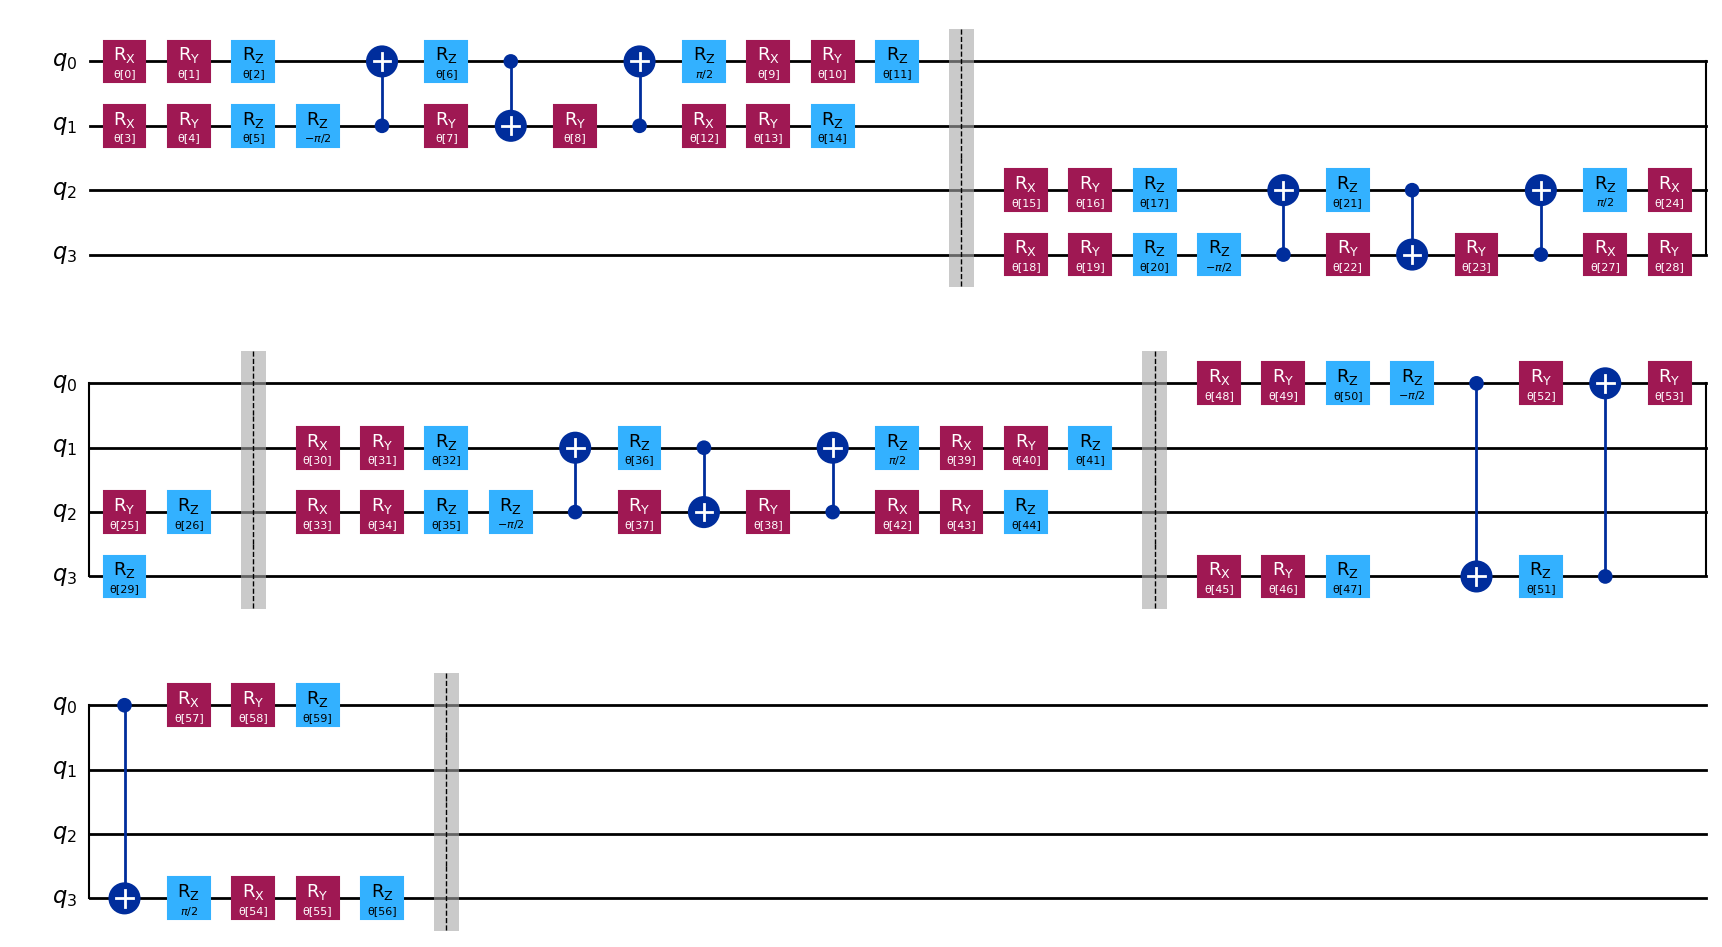

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

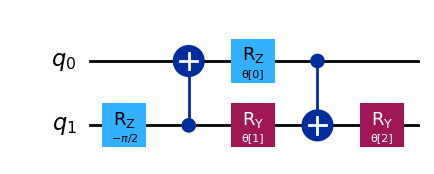

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

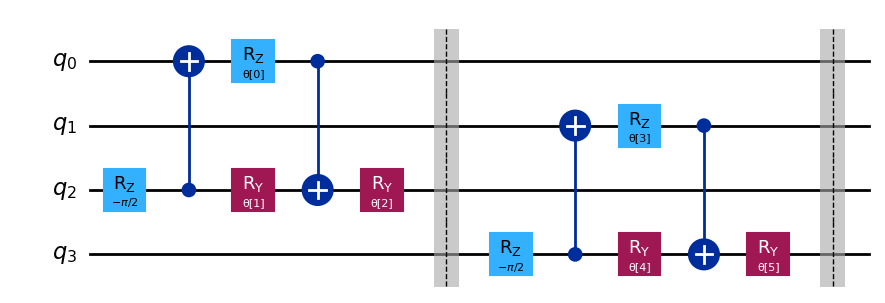

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [6]:
import tensorflow as tf
import collections
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [7]:
def filter_3649(x, y):
    keep = (y == 1) | (y == 2)| (y == 4)
    x, y = x[keep], y[keep]
    # y = y == 3
    return x,y

In [8]:
x_train, y_train = filter_3649(x_train, y_train)
x_test, y_test = filter_3649(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 18542
Number of filtered test examples: 3149


4


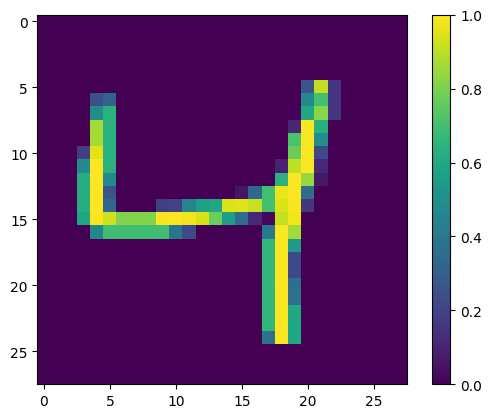

In [9]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [10]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

4


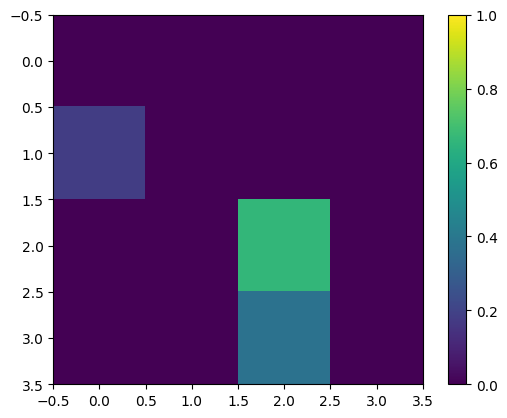

In [11]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [12]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and 1 in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and 2 in value)
    num_uniq_4 = sum(1 for value in mapping.values() if len(value) == 1 and 4 in value)
    num_uniq_9 = sum(1 for value in mapping.values() if len(value) == 1 and 9 in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) >= 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 1s: ", num_uniq_3)
    print("Number of unique 2s: ", num_uniq_6)
    print("Number of unique 4s: ", num_uniq_4)
    print("Number of unique 9s: ", num_uniq_9)
    print("Number of unique contradicting labels: ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.asarray(new_x), np.asarray(new_y)

In [13]:
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 12428
Number of unique 1s:  1886
Number of unique 2s:  4915
Number of unique 4s:  5240
Number of unique 9s:  0
Number of unique contradicting labels:  387

Initial number of images:  18542
Remaining non-contradicting unique images:  12041
Number of unique images: 2353
Number of unique 1s:  451
Number of unique 2s:  912
Number of unique 4s:  941
Number of unique 9s:  0
Number of unique contradicting labels:  49

Initial number of images:  3149
Remaining non-contradicting unique images:  2304


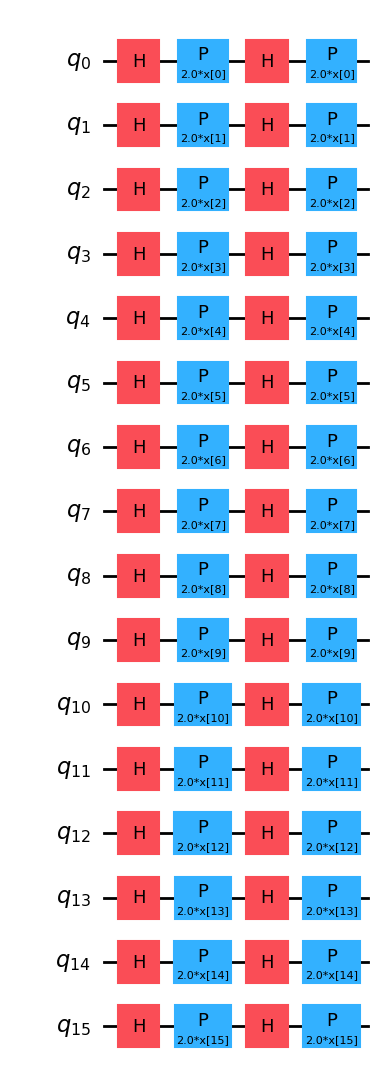

In [14]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

In [15]:
feature_map = ZFeatureMap(16)
ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# # Fourth Convolutional Layer
# ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# # Fourth Pooling Layer
# ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

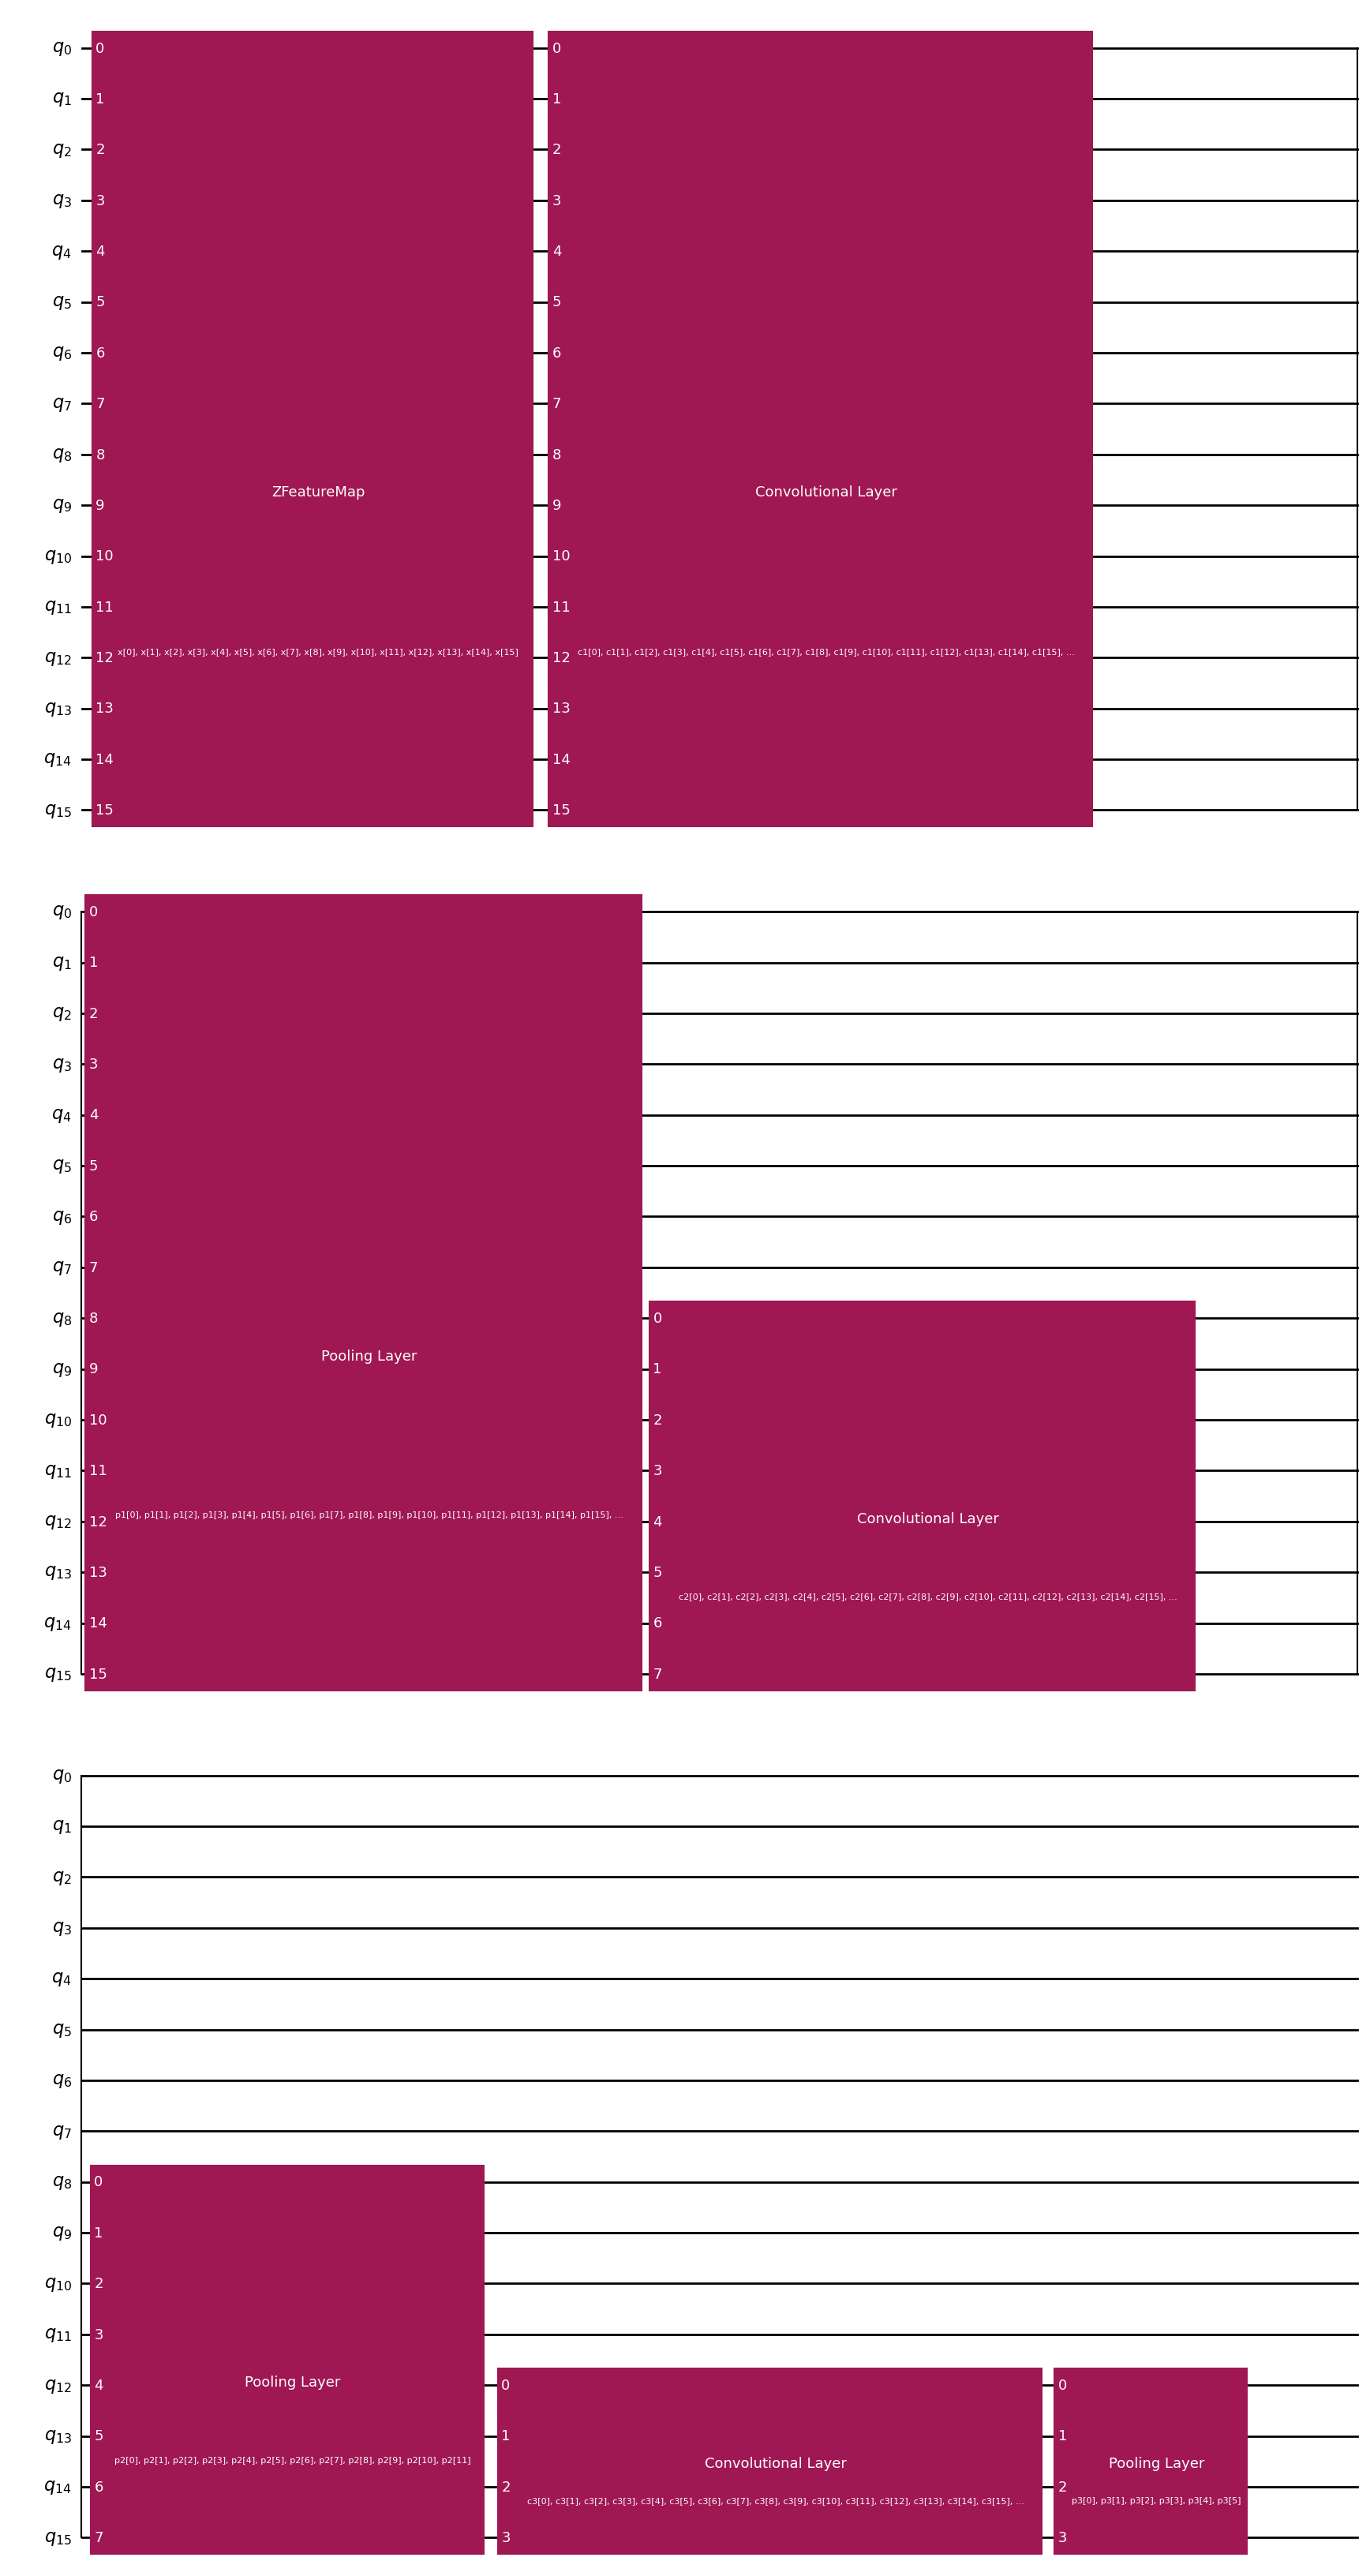

In [16]:
circuit.draw("mpl")

In [17]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    
  
    print("weights", weights)
    print("objective function value", objective_func_vals)
    
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [18]:
# construct variational quantum classifier
# weights = [2.08713408e+01 9.69442426e-01 2.06494753e+01 2.03016238e+01
#  8.38673732e-01 5.91347668e-01 1.86835653e+00 2.15726074e+01
#  5.35566810e-01 1.02724726e+00 7.66485468e-01 1.76930374e+00
#  1.15558349e-01 5.60979716e-01 7.70304514e-01 5.10305683e-01
#  1.81970714e-01 9.96455077e-02 9.03654103e-01 7.13858530e-01
#  3.81401593e-01 2.24001140e-01 3.17102724e-01 3.68597993e-01
#  4.79552292e-01 1.28201698e-01 8.86695711e-01 6.98318152e-01
#  8.10926111e-01 6.81025099e-01 4.05816270e-01 9.95904230e-03
#  2.42555762e-02 7.06494904e-01 4.80815891e-01 9.08096550e-02
#  1.83550847e-01 8.67463660e-01 7.89718793e-03 5.23676210e-01
#  4.83620087e-01 1.42242154e-01 5.86965447e-01 3.46898045e-01
#  1.72047730e-01 4.25815796e-01 4.47743980e-01 1.21138523e+00
#  1.95158692e+00 3.25970366e-01 6.31133238e-02 6.94112841e-01
#  3.42171169e-01 3.62972489e-01 1.65090763e-01 3.28341676e-01
#  7.33638678e-01 3.57879283e-01 6.31370438e-01 8.26089957e-01
#  7.16214502e-01 2.02936973e-01 5.23099165e-02 6.96915759e-01
#  1.03508971e-01 6.06925412e-01 9.13982098e-02 1.14591331e-01
#  2.52012917e-01 9.63696757e-01 4.19835306e-01 7.84639901e-01
#  2.16006146e-01 2.30343637e-01 7.80622010e-01 9.49516422e-02
#  3.92230113e-01 4.20016449e-01 4.74021934e-01 9.34243640e-01
#  5.71833171e-02 1.50290763e-01 5.25027831e-01 5.29635049e-01
#  4.20129599e-02 7.04146275e-01 6.49464383e-01 4.40471533e-01
#  9.34868406e-02 8.47444906e-01 7.22613442e-01 6.90302526e-01
#  7.52876130e-01 4.13134986e-02 4.77260120e-01 4.80581957e-01
#  8.38911532e-01 6.48595940e-01 3.20456449e-01 6.45069288e-01
#  3.38224545e-01 1.38119904e-01 3.53391372e-01 9.15791753e-02
#  5.01141220e-01 5.09925867e-01 1.78963246e-01 8.97796373e-04
#  6.99780082e-01 9.58105505e-01 7.61130600e-01 8.07363210e-02
#  7.10834150e-01 3.68351482e-01 9.84709644e-01 9.21112268e-01
#  8.44173091e-01 5.10679238e-01 6.94451057e-01 9.95754243e-01
#  5.87682096e-01 8.74509153e-02 8.08771701e-01 6.54169132e-01
#  9.10006472e-01 9.91258031e-01 2.63844356e-01 7.25236642e-03
#  9.73872415e-01 2.19216492e-01 4.39770067e-01 7.81124781e-01
#  1.25632165e-02 8.90434434e-01 8.90459239e-01 1.16424251e-01
#  1.93670640e-01 3.74420901e-02 4.05237140e-01 3.30965051e-01
#  5.54630748e-01 7.45286743e-01 4.37644940e-01 5.60380363e-01
#  8.02178042e-01 3.34418168e-01 5.16413468e-01 1.19311625e-01
#  1.78721235e-01 3.23156385e-01 7.74644336e-01 8.37013082e-01
#  3.26678850e-01 3.61256099e-01 9.39704066e-01 5.57896919e-01
#  5.77430956e-01 5.31225879e-01 4.24296499e-01 6.63552061e-01
#  3.91647619e-01 1.87661753e-01 8.73535645e-03 7.65984431e-01
#  7.14672605e-01 3.67435649e-01 6.58672998e-01 2.89352220e-01
#  4.81398548e-01 9.66381311e-01 1.00523226e-01 2.79559888e-01
#  9.00965751e-01 7.31045429e-01 6.47540285e-01 6.21504597e-01
#  3.57847851e-01 7.86833666e-01 5.55043134e-01 2.56974676e-02
#  2.91987249e-01 5.08576789e-01 5.01472890e-02 8.02315181e-01
#  1.37218959e-01 9.75406777e-01 6.99186841e-01 1.73631908e-01
#  4.77033043e-01 2.43269621e-01 9.78989285e-01 9.11104163e-01
#  5.40078158e-01 1.75171507e-02 2.56138084e-01 6.83087751e-01
#  8.07849767e-01 4.51961656e-01 8.06717619e-02 9.16042019e-01
#  2.82928451e-01 4.86740529e-01 4.16291246e-01 1.78671802e-01
#  3.04981607e-01 1.38797397e-01 8.73225448e-01 8.69136195e-01
#  3.61594546e-01 9.80698234e-01 4.61686324e-01 6.14086844e-01
#  6.79519619e-01 1.77819586e-01 6.26772594e-02 2.55353927e-01
#  3.10111974e-01 3.60341134e-01 9.28054467e-01 8.36517523e-01
#  3.17231084e-01 2.24897328e-01 1.42884813e-01 9.64642142e-01
#  7.99896899e-01 3.23919578e-01 2.50822312e-01 6.98822209e-01
#  7.05892439e-01 5.61837822e-01 4.85767691e-02 2.57543880e-01
#  3.77909365e-01 7.38248335e-01 7.49530751e-01 6.57926250e-01
#  9.15088151e-01 7.61467726e-01 5.46076142e-01 3.92912526e-01
#  8.81942382e-01 6.68322270e-01 9.57136440e-01 3.79161198e-01
#  4.40675647e-01 6.84309872e-01 8.62593385e-01 2.15752638e-01
#  8.43722397e-01 9.38086084e-01 3.84613185e-02 6.47350318e-01
#  7.90091858e-02 2.76987651e-01 6.39618155e-01 8.65124052e-01
#  3.60785497e-01 5.13444918e-01 7.98050076e-01 7.50598825e-01
#  9.12018522e-01 1.38627060e-01 8.81285639e-01 4.97857438e-01
#  8.75855734e-01 6.91811106e-01 3.74970997e-01 9.16085809e-01
#  2.85619691e-03 2.68728916e-01 4.76075361e-01 1.09152718e-01
#  2.81789874e-02 4.21123727e-01 6.82529104e-01 4.05563484e-01
#  5.50159528e-01 2.02122291e-01 9.97297549e-01 8.00891323e-01
#  4.98946907e-01 9.74772983e-01 2.34917028e-01 5.54115388e-01
#  2.07241859e-01 1.43033542e-01 1.72808933e-02 6.17434296e-01
#  7.59083807e-01 5.03761433e-01 7.46247999e-01 2.00243851e-01
#  9.43347527e-01 9.28844994e-01 1.42821649e-01 3.70438765e-01
#  3.49062725e-01 2.51276380e-01 7.59617383e-01 3.05026555e-01
#  9.96064529e-01 6.18375778e-01 5.18180457e-01 4.52564100e-01
#  2.00089869e-01 6.73638371e-01 9.51113027e-01 3.14038825e-02
#  4.45942891e-01 3.33918708e-02 7.40978875e-01 8.30967522e-01
#  5.77130038e-01 6.72672674e-01 6.91033306e-01 6.07881490e-01
#  3.67029300e-01 1.59710505e-01 8.48123335e-01 3.28286297e-01
#  2.84725716e-01 2.34602001e-01 9.09859613e-01 5.01405009e-01
#  8.39723055e-01 9.22705418e-01 9.60365446e-01 5.34967716e-02
#  8.15947352e-01 2.47514091e-01 1.33299185e-01 3.16078371e-01
#  2.57508001e-01 2.50103278e-01 2.28674113e-01 9.47266122e-01
#  5.44529659e-03 7.27462191e-02 7.58036423e-01 4.19363722e-01
#  9.54189807e-01 7.38777602e-01 9.49965020e-01 8.10222371e-01
#  1.55912098e-01 7.12503905e-01 5.72203034e-01 4.70545476e-01
#  1.92905552e-01 6.88174576e-01 7.58153500e-01 3.32931259e-01
#  9.84761551e-01 3.25488480e-01 5.22895788e-01 3.37964919e-01
#  9.84300807e-01 8.57248380e-01 9.74974804e-01 6.91021186e-01
#  1.92831910e-01 7.39133913e-01 9.00494299e-01 8.50129523e-01
#  6.48058260e-01 1.33772620e-04 8.69139920e-02 8.46603814e-01
#  3.35244934e-01 1.85411447e-01 7.24326059e-01 3.47432774e-01
#  5.34843684e-01 8.37033143e-01 3.49542294e-02 8.87437767e-01
#  4.64174541e-01 4.97221885e-01 3.21066069e-01 7.90087499e-01
#  6.74595788e-01 2.59478081e-01 7.51526880e-01 3.63451601e-01
#  6.49644416e-01 9.60521249e-01 2.19017712e-01 5.95295109e-01
#  3.36060224e-02 8.26454717e-01 3.99218686e-01 9.39882170e-01
#  6.54553089e-01 6.73250871e-01 4.35344987e-01 1.88248993e-01
#  9.63136087e-01 6.98458604e-01 7.65282962e-01 7.19175495e-01
#  5.25149220e-03 3.93093538e-01 8.72593878e-01 2.02609567e-01
#  6.32053801e-01 8.64070390e-01 2.49399442e-01 3.23712003e-01
#  4.67087188e-01 8.44994375e-01 4.41094843e-01 7.44869508e-01
#  5.33812868e-01 9.99731100e-01 9.45560767e-04 2.40194135e-01
#  1.89224052e-01 5.49054315e-01 5.80672233e-01 9.04104486e-01
#  5.07660233e-02 7.03670415e-01 4.11233999e-01 3.35837327e-01
#  4.98207364e-01 7.86211668e-01 3.44479865e-01 2.48312946e-01
#  3.00853957e-01 4.83822573e-01 2.16648071e-01 2.54558214e-01
#  3.12703441e-01 5.23181939e-01 1.64847494e-01 8.12032676e-02
#  6.17284116e-01 9.85046161e-02 7.15370638e-01 3.82451567e-02
#  4.92825673e-01 3.66900409e-01 8.64758398e-01 8.92942423e-01
#  5.98076267e-01 8.06652254e-01 8.75995961e-01 5.73681128e-01
#  6.93731027e-01 2.51785502e-01 2.81921425e-01 4.78721347e-01
#  7.05155281e-01 5.25420454e-01 5.32660289e-01 4.89443330e-01
#  6.39395951e-01 9.65172816e-01 9.18913432e-02 2.64503706e-01
#  8.62304943e-01 5.77180018e-01]

classifier = VQC(
    feature_map=feature_map.decompose(),
    ansatz=ansatz.decompose(),
    optimizer=COBYLA(maxiter=50),
    callback=callback_graph,
    warm_start = True,
    initial_point = weights
)

In [19]:
# y_int = []
# for a in train_labels:
#     if a:
#         y_int.append(1)
#     else: 
#         y_int.append(-1)
        
# y1_int = []
# for a in test_labels:
#     if a:
#         y1_int.append(1)
#     else: 
#         y1_int.append(-1)

x_reshaped = []
x1_reshaped = []

for b in resized_train_images:
    x_reshaped.append(b.reshape(1,16))

for b in resized_test_images:
    x1_reshaped.append(b.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    #print("entry \n" , entry[0])
    final_x.append(entry[0])

for entry in x1_reshaped:
    #print("entry \n" , entry[0])
    final_x1.append(entry[0])

objective_func_vals = []

x = np.asarray(final_x)
y = np.asarray(train_labels)

x = x[:500]
y = y[:500]

print(x)
print(y)

# def convert_to_onehot(arr):
#     encoded_arr = np.zeros((arr.size, arr.max()+1), dtype=int)
#     encoded_arr[np.arange(arr.size),arr] = 1
#     print(encoded_arr)
# y = convert_to_onehot(y)

[[0.         0.         0.         ... 0.         0.3764706  0.        ]
 [0.         0.         0.         ... 0.99215686 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[4 1 2 4 1 1 2 4 2 4 4 1 4 4 4 1 1 1 2 4 4 1 1 2 1 4 2 2 4 4 1 4 4 2 4 2 2
 4 4 4 2 1 2 2 2 4 2 1 1 2 4 2 4 1 2 4 2 2 4 2 2 4 4 4 2 4 1 4 4 1 4 2 2 2
 4 4 4 2 4 2 1 4 2 4 2 4 4 2 2 4 2 2 2 2 1 2 4 2 4 4 1 2 4 4 2 1 2 1 2 4 1
 1 1 2 2 4 1 1 1 2 2 4 1 1 4 2 2 1 1 2 1 2 2 4 2 4 2 1 4 2 4 1 2 4 4 4 1 4
 1 2 1 2 2 1 4 2 4 2 1 2 4 4 1 4 2 4 1 4 1 2 2 2 4 4 4 2 4 4 4 4 1 2 1 1 4
 2 4 2 1 2 2 4 2 1 4 1 1 4 2 4 4 4 2 4 2 2 2 1 1 2 4 4 2 4 4 4 4 2 4 2 1 4
 2 4 2 1 4 2 1 1 1 4 1 1 4 4 4 1 1 4 4 4 2 2 1 1 4 1 2 2 4 2 4 1 2 4 2 1 1
 1 4 1 2 4 4 4 1 2 2 4 2 2 1 1 

weights [2.08713408e+01 9.69442426e-01 2.06494753e+01 2.03016238e+01
 8.38673732e-01 5.91347668e-01 1.86835653e+00 2.15726074e+01
 5.35566810e-01 1.02724726e+00 7.66485468e-01 1.76930374e+00
 1.15558349e-01 5.60979716e-01 7.70304514e-01 5.10305683e-01
 1.81970714e-01 9.96455077e-02 9.03654103e-01 7.13858530e-01
 3.81401593e-01 2.24001140e-01 3.17102724e-01 3.68597993e-01
 4.79552292e-01 1.28201698e-01 8.86695711e-01 6.98318152e-01
 8.10926111e-01 6.81025099e-01 4.05816270e-01 9.95904230e-03
 2.42555762e-02 7.06494904e-01 4.80815891e-01 9.08096550e-02
 1.83550847e-01 8.67463660e-01 7.89718793e-03 5.23676210e-01
 4.83620087e-01 1.42242154e-01 5.86965447e-01 3.46898045e-01
 1.72047730e-01 4.25815796e-01 4.47743980e-01 1.21138523e+00
 1.95158692e+00 3.25970366e-01 6.31133238e-02 6.94112841e-01
 3.42171169e-01 3.62972489e-01 1.65090763e-01 3.28341676e-01
 7.33638678e-01 3.57879283e-01 6.31370438e-01 8.26089957e-01
 7.16214502e-01 2.02936973e-01 5.23099165e-02 6.96915759e-01
 1.03508971e-01 

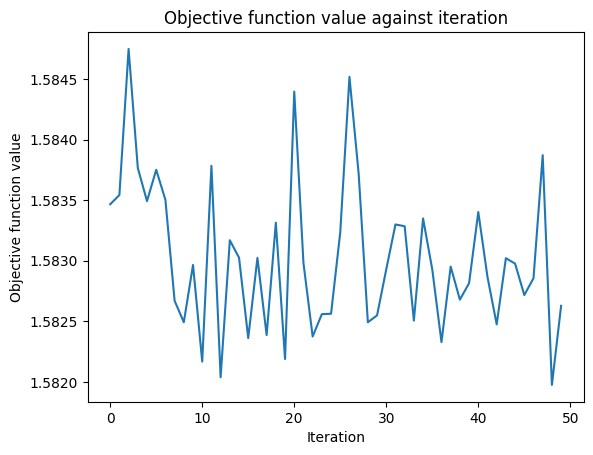

Accuracy from the train data : 50.2%


In [20]:
classifier.fit(x, y)
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [21]:
x1 = np.asarray(final_x1)
y1 = np.asarray(test_labels)
        
x1 = x1[:1000]
y1 = y1[:1000]
y_predict = classifier.predict(x1)

print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

Accuracy from the test data : 45.8%


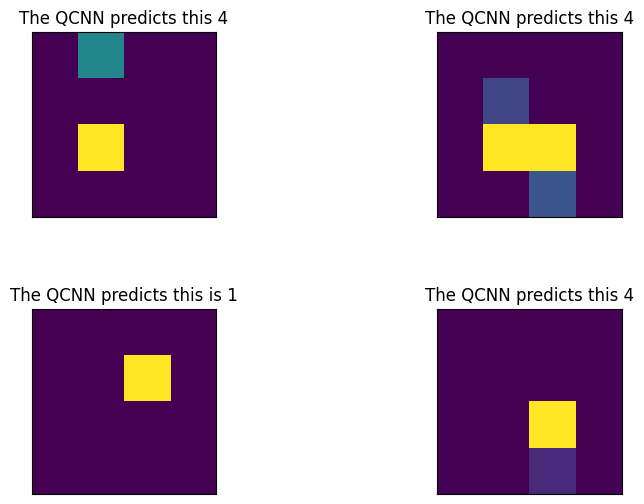

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 1")
    if y_predict[i] == 2:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 2")
    if y_predict[i] == 4:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")   
    # if y_predict[i] == 9:
    #     ax[i // 2, i % 2].set_title("The QCNN predicts this 9") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [27]:
y_predict

array([4, 4, 1, 4, 2, 4, 4, 4, 4, 4, 1, 4, 2, 1, 2, 4, 4, 4, 4, 4, 4, 4,
       1, 1, 4, 4, 4, 1, 4, 1, 2, 4, 2, 1, 2, 1, 1, 4, 2, 2, 4, 4, 4, 1,
       4, 1, 1, 2, 4, 1, 4, 4, 4, 2, 1, 1, 4, 4, 4, 1, 4, 1, 1, 4, 1, 4,
       4, 1, 4, 4, 4, 1, 4, 4, 2, 1, 2, 1, 1, 4, 4, 1, 1, 4, 1, 2, 4, 4,
       1, 1, 2, 1, 2, 4, 4, 1, 4, 1, 4, 4, 4, 4, 2, 4, 1, 4, 1, 1, 1, 4,
       4, 1, 4, 4, 1, 4, 1, 1, 1, 2, 1, 2, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4,
       1, 4, 4, 4, 4, 1, 4, 2, 1, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 2, 4, 4,
       1, 4, 1, 1, 4, 4, 1, 2, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 1, 4, 1, 4,
       4, 4, 4, 4, 4, 2, 1, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 1, 1, 1, 1, 1,
       1, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 2, 4, 4,
       2, 1, 2, 4, 4, 4, 4, 2, 4, 2, 4, 4, 1, 4, 4, 2, 1, 4, 4, 4, 4, 1,
       1, 2, 4, 1, 2, 1, 1, 2, 4, 2, 2, 4, 4, 4, 2, 1, 4, 4, 1, 2, 4, 4,
       2, 4, 1, 1, 4, 1, 1, 2, 4, 4, 1, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4,
       4, 2, 1, 1, 4, 2, 4, 4, 4, 1, 1, 4, 1, 4, 4,